In [1]:
# !pip install git+https://github.com/Peltarion/pmqd#egg=pmqd
# !pip install librosa matplotlib
# !pip install torchaudio==0.11.0
# !pip install pytorch-msssim

In [1]:
import itertools
import random
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio.transforms as T
from IPython.display import Audio
from IPython.core.display_functions import display
from librosa.display import specshow
from pmqd.torch import PMQD
from torch.utils.data import Dataset, DataLoader, Subset

from pyramids import LaplacianPyramid
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy.stats import spearmanr
import pandas as pd


/Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <C0CD941A-7290-3098-8109-E3A1BBA30841> /Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <FD4DD173-D62C-3EAA-80A5-252A577C0547> /Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Create Data

Load the dataset and extract the sample rate.

In [2]:
dataset = PMQD(root="/Users/up20938/Coding/datasets/pmqd", download=False)
sample_rate = PMQD.SAMPLE_RATE

Create a Torch Dataset.

In [11]:
ratings = []
for e,i in enumerate(dataset, start=1):
    ratings.append(i['rating'])

KeyError: 975

In [38]:
""""
get class weights for cross entropy loss over ratings
"""
ratings = np.array(ratings,dtype=int)
vc = np.unique(ratings, return_counts=True)
w = vc[1]/vc[1].sum()
w = (1/w)
w = w/w.sum()
print(w)

[0.31 0.18 0.11 0.06 0.35]


In [39]:
class TransformedPMQD(Dataset):
    """Transform the first channel of audio and return it together with the rating."""
    
    def __init__(self, dataset: PMQD, transforms: nn.Sequential):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        example = self.dataset[n]
        # channel = example["audio"][0]
        channel = example["audio"].mean(axis=0)

        # return self.transforms(channel), example["rating"]
        return self.transforms(channel), example

Set spectrogram parameters for torchaudio.

In [40]:
""" 256 x 512 images """
# reduced_sample_rate = 16000
# window_size = 4096
# hop_size = 387
# num_mels = 512

""" 512 x 1024 images"""
reduced_sample_rate = 16050
window_size = 2048
hop_size = 64
num_mels = 512

In [41]:
transforms = nn.Sequential(
    T.Resample(orig_freq=sample_rate, new_freq=reduced_sample_rate),
    T.MelSpectrogram(
        n_mels=num_mels,
        n_fft=window_size,
        win_length=window_size,
        hop_length=hop_size,
        power=1,
        center=False,
        sample_rate=reduced_sample_rate,
        f_min=0,
        f_max=reduced_sample_rate / 2,
        window_fn=torch.hann_window,
        mel_scale='htk',
        norm=None
    ),
)

/Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


Create spectrograms for each audio clip and print an example of each distortion type.

tensor(0) One More Holy Night original tensor(4., dtype=torch.float64)


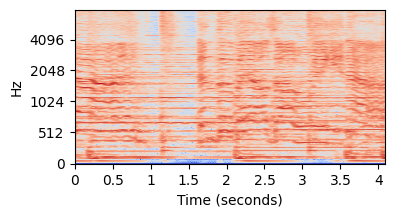

tensor(195) One More Holy Night distortion tensor(2., dtype=torch.float64)


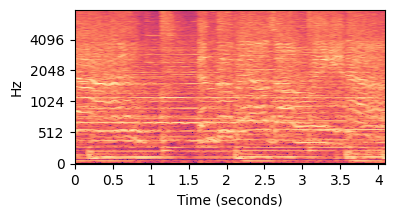

tensor(390) One More Holy Night limiter tensor(4., dtype=torch.float64)


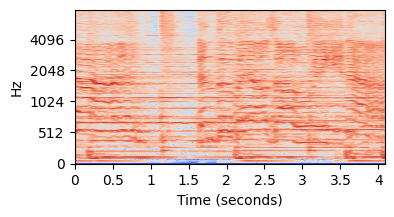

tensor(585) One More Holy Night lowpass tensor(3., dtype=torch.float64)


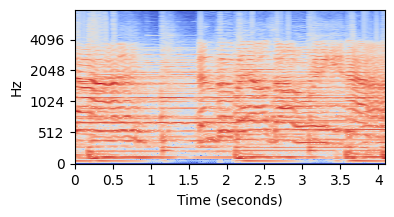

tensor(780) One More Holy Night noise tensor(2., dtype=torch.float64)


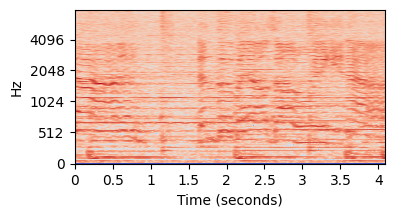

In [42]:
dataloader = DataLoader(TransformedPMQD(dataset, transforms), batch_size=195)
omhn = []
rts = []

for mel_spectrograms, rating in itertools.islice(dataloader, 0, 5):
    print(rating['id'][0], rating['title'][0], rating['degradation_type'][0], rating['rating'][0].data)
    fig, ax = plt.subplots(1, figsize=(4,2))
    omhn.append(mel_spectrograms)
    rts.append(rating['rating'])
    specshow(
        torch.log(mel_spectrograms[0] + 1e-3).numpy(),
        sr=reduced_sample_rate,
        hop_length=hop_size,
        x_axis="s",
        y_axis="mel"
    )
    plt.show()

Set up a Laplacian Pyramid and plot the output at each layer.

torch.Size([1, 1, 512, 1024])


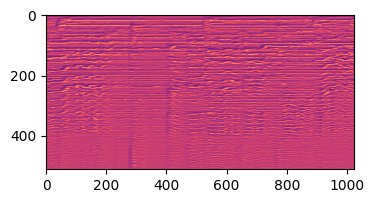

torch.Size([1, 1, 256, 512])


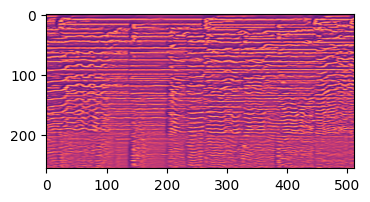

torch.Size([1, 1, 128, 256])


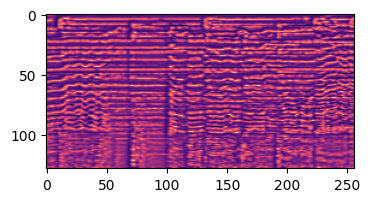

torch.Size([1, 1, 64, 128])


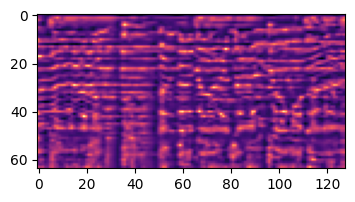

torch.Size([1, 1, 32, 64])


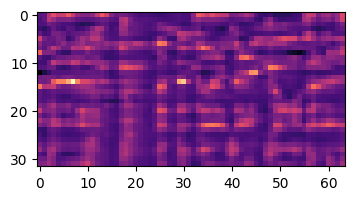

torch.Size([1, 1, 16, 32])


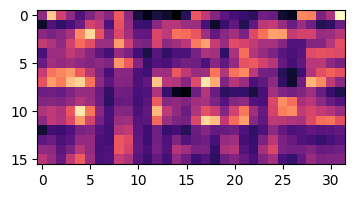

In [43]:
pmd = LaplacianPyramid(6,dims=1)
pyr = pmd.pyramid(omhn[0][0].unsqueeze(0).unsqueeze(0).float())
for i in range(len(pyr)):
    pi = pyr[i]
    print(pi.shape)
    pi = (pi + abs(pi.min()))/(pi + abs(pi.min())).max()
    fig, ax = plt.subplots(1, figsize=(4,2))
    plt.imshow(pi.squeeze(),cmap='magma')
    plt.show()

### Calculate Correlations

In [47]:
from importlib import reload

In [48]:
import cnn

In [56]:
reload(cnn)

/Users/up20938/Coding/python/audio-pyramid/cnn.py:187: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pretrained and normalisation is not "gdn":


<module 'cnn' from '/Users/up20938/Coding/python/audio-pyramid/cnn.py'>

In [57]:
cnns = cnn.cnn_preds()

In [13]:
cnns

tensor([1.7229, 1.1710, 1.3195, 2.9445, 1.9206, 2.5062, 2.4899, 2.4246, 2.4956,
        2.7245, 1.6430, 2.8063, 2.6322, 2.6330, 1.1695, 1.6626, 1.2721, 2.5940,
        1.9381, 2.5921, 1.1757, 2.0260, 2.9513, 2.8804, 2.7342, 1.4237, 2.3305,
        2.0052, 2.3202, 1.5289, 1.8468, 1.4574, 2.6903, 2.1767, 2.5843, 2.3615,
        2.5082, 2.9343, 1.8356, 0.8712, 1.8997, 2.8762, 2.5015, 2.2813, 2.5095,
        2.3215, 2.5644, 1.9691, 1.7505, 2.1936, 2.3816, 2.4137, 0.8439, 2.0354,
        2.9400, 1.7487, 1.3244, 2.7026, 2.6940, 2.7218, 2.0620, 1.3415, 1.4572,
        2.0468, 2.7342, 2.1721, 2.4502, 2.1321, 2.5576, 1.8623, 2.5141, 2.0748,
        1.4551, 2.4680, 2.7810, 1.3602, 1.9453, 0.7563, 1.5217, 2.3170, 2.7950,
        1.4770, 2.0014, 2.2591, 1.9368, 2.9264, 1.6460, 2.0387, 2.4255, 2.3198,
        2.0728, 2.8788, 2.2804, 2.9155, 2.2543, 2.6987, 2.8437, 1.7350, 2.2637,
        2.4002, 2.3818, 1.7630, 2.0808, 1.8498, 2.8875, 1.5991, 2.3116, 2.9408,
        2.8286, 2.9177, 2.6104, 1.9533, 

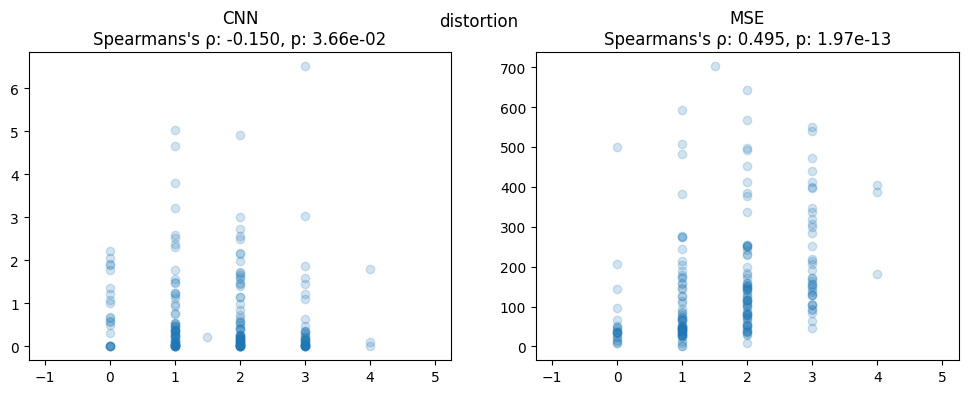

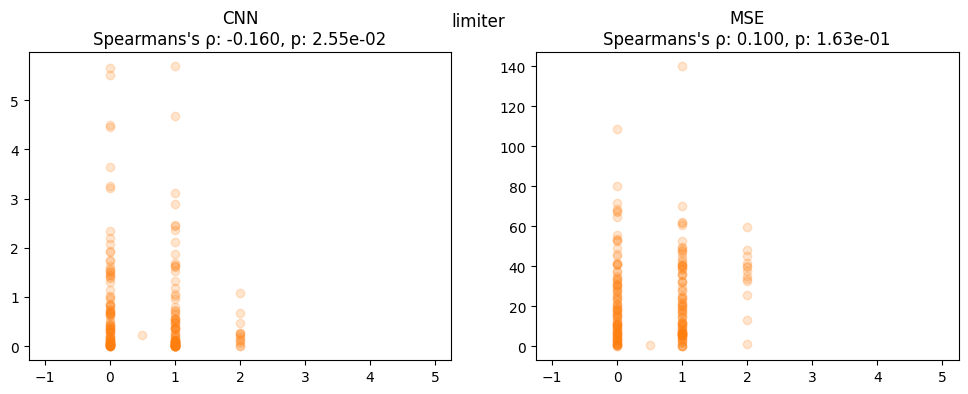

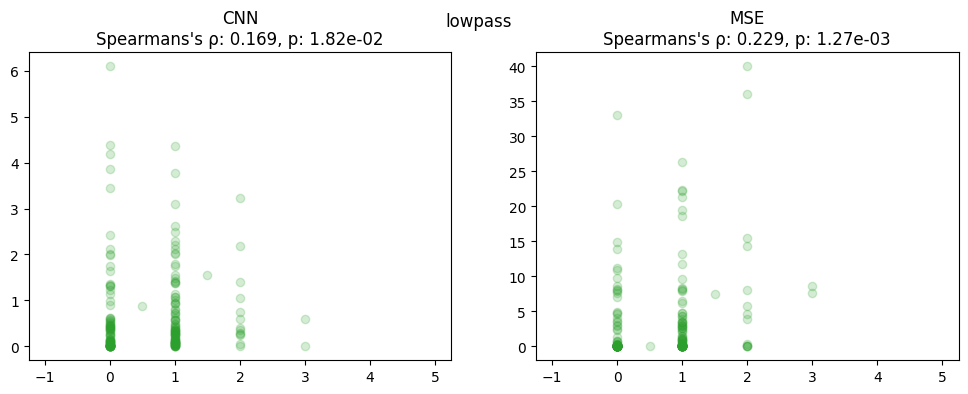

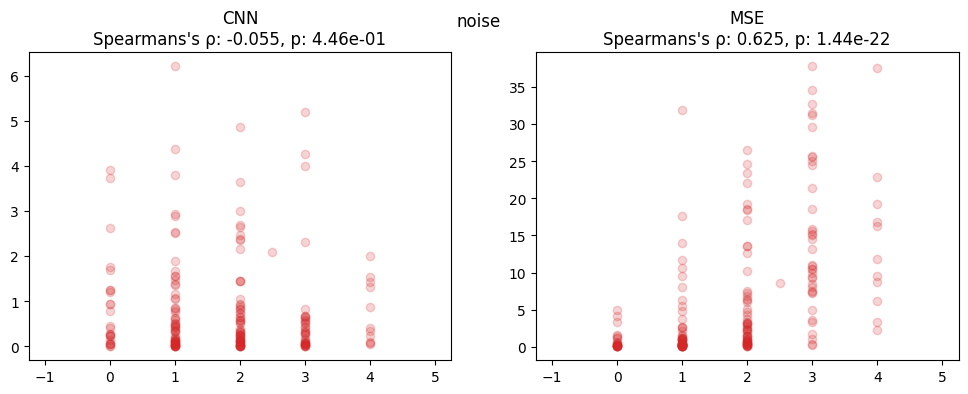

In [26]:
distortions = ['distortion','limiter','lowpass','noise']
combinations = ((0,1),(0,2),(0,3),(0,4))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i1, i2 in combinations:
    cnndiff = []
    radiff = []
    mse = []
    for j in range(195):
        cnndiff.append((cnns[i1+j]-cnns[(i2*195)+j])**2)
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,cnndiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 1.25
    yoffset = 1

    ax[0].set_title(f"CNN\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,cnndiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

In [ ]:
"""
cnn norm-1: [-.150, -.160, .169, -.055]

"""

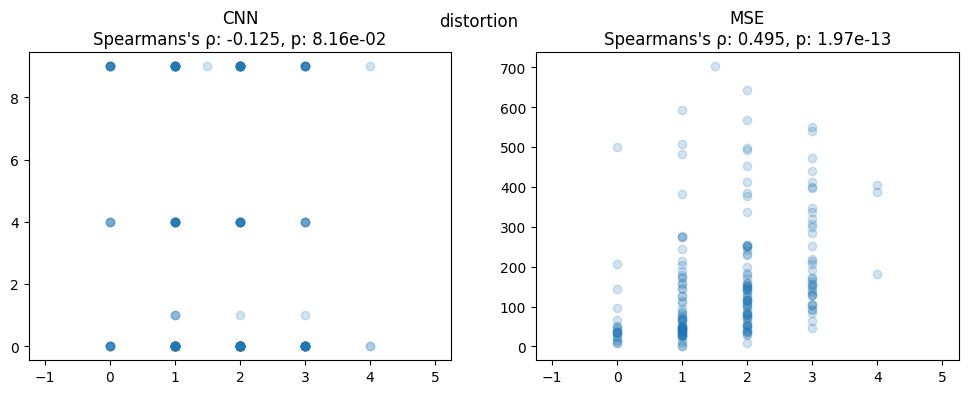

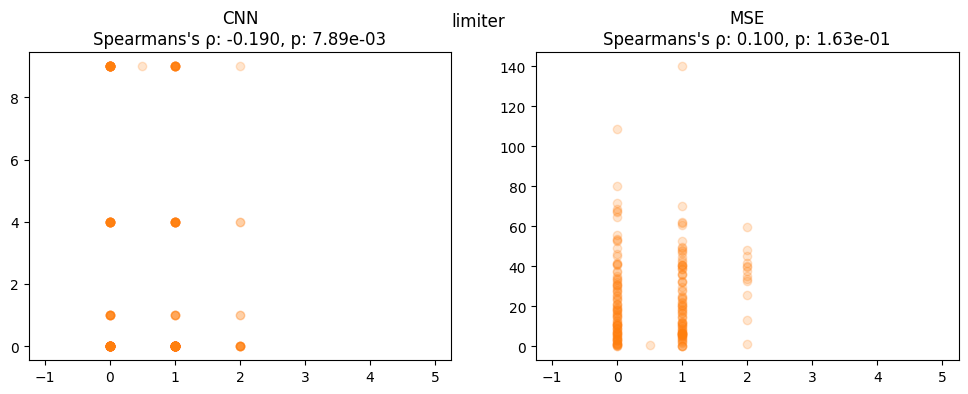

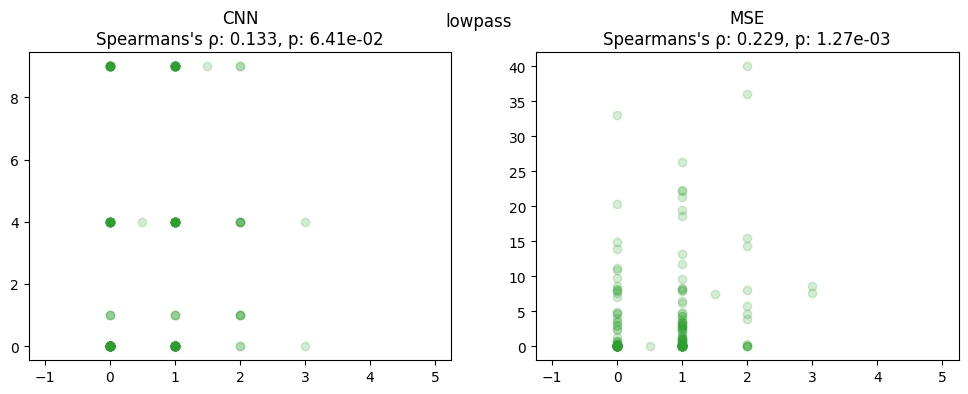

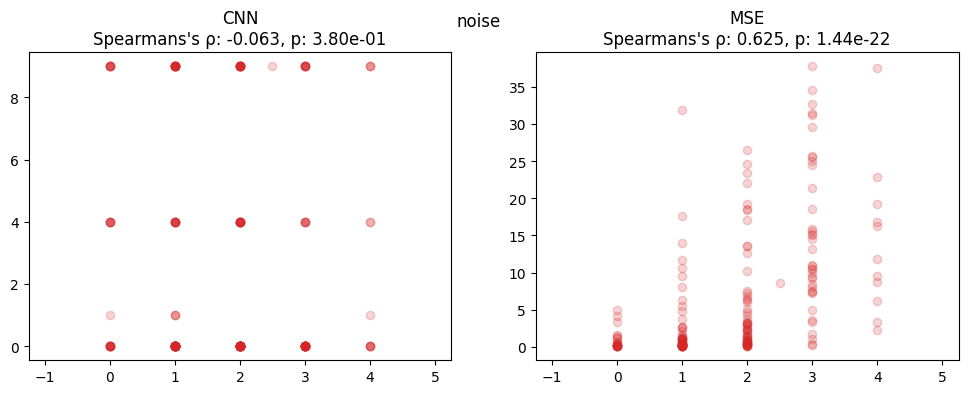

In [58]:
distortions = ['distortion','limiter','lowpass','noise']
combinations = ((0,1),(0,2),(0,3),(0,4))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i1, i2 in combinations:
    cnndiff = []
    radiff = []
    mse = []
    for j in range(195):
        cnndiff.append((cnns[i1+j]-cnns[(i2*195)+j])**2)
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,cnndiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 1.25
    yoffset = 1

    ax[0].set_title(f"CNN\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,cnndiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

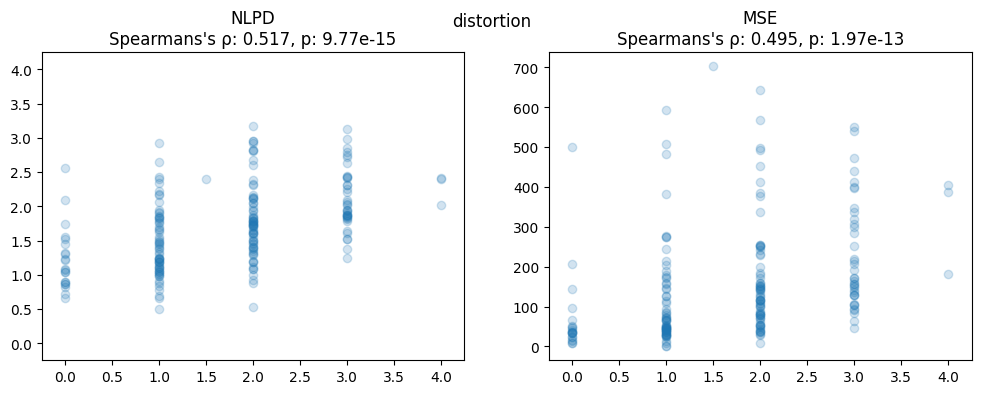

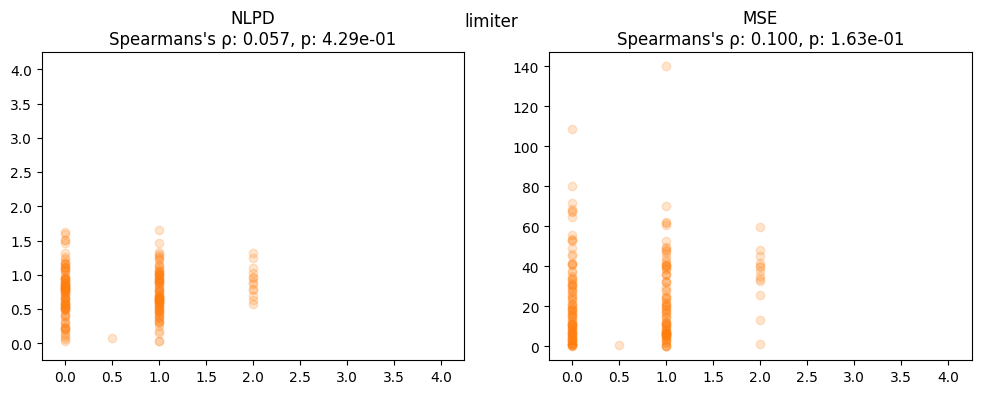

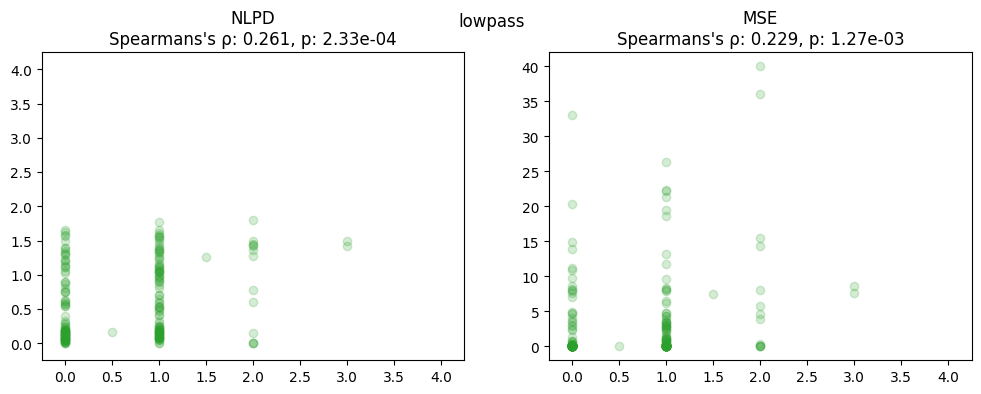

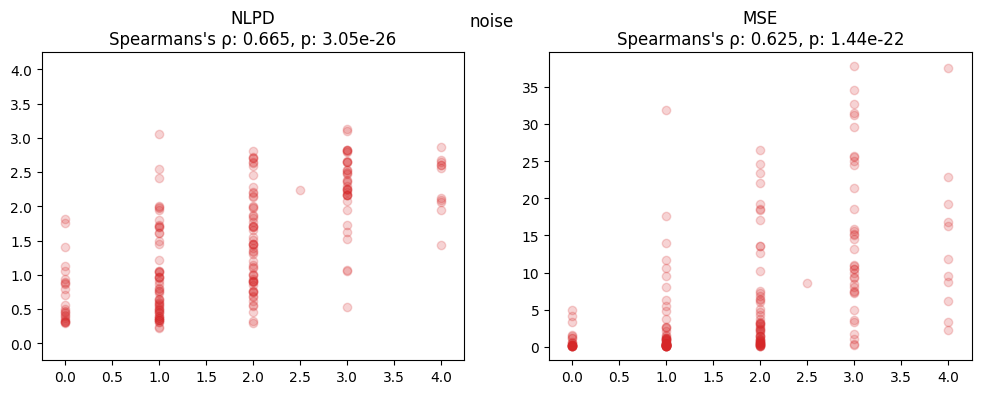

In [45]:
distortions = ['distortion','limiter','lowpass','noise']
combinations = ((0,1),(0,2),(0,3),(0,4))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn[i1][j].unsqueeze(0).unsqueeze(0).float(), omhn[i2][j].unsqueeze(0).unsqueeze(0).float()))
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,pmdiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 0.25

    ax[0].set_title(f"NLPD\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,pmdiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_xlim(0-xoffset,4+xoffset)
    ax[0].set_ylim(0-yoffset,4+yoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

In [ ]:
"""
pairs: [.517,.057,.261,.665]
similar correlation, but y-scale better matches ratings
"""

In [ ]:
"""
no div norm: [.505,.107,.236,.590] (z)
abs: [.503,.108,.236,.578] (abs(z))
zero filter: [.473,.025,.246,.643] (all zeros but one centre)
one filter: [.511,.072,.274,.674] (all ones but zero centre)
ten filter: [.506,.115,.270,.652] (all tens but zero centre)
"""

In [ ]:
"""
trained on layer sum 50 epoch, 3 layers: [.518,.105,.251,.667]
100 epoch: [.514,.129,.255,.661]
100 x 6: [.507,.111,.274,.660]
"""

In [ ]:
"""
# norm 0.6
layers = {'layer1':[.485,.031,.245,.615], 'layer2':[.487,.025,.244,.618], 'layer3':[.481,.028,.245,.621],
          'layer4':[.475,.031,.241,.624], 'layer5':[.463,.025,.241,.628], 'layer6':[.462,.021,.241,.630]}
mse = [.495,.100,.229,.625]
"""

In [ ]:
"""
# norm 1
norm1 = [.461,.022,.239,.629]
# norm 0.3
norm03 = [.464,.022,.240,.630]
"""

In [ ]:
"""
reduced_sample_rate = 16000
window_size = 2048
num_mels = 256
varying hop size:
{2041.32: [.492,.159,.331,.615],
 1021.64: [.500,.152,.321,.622],
 511.128: [.505,.146,.305,.626],
 128.512:[.473,.090,.277,.612]}
window_size = 2048
hop_size = 256
num_mels = 256
vary sample rate
{124.8000:[.458,.097,.111,.595],
 519.32000: [.498, .105,.270,.635],
 782.48000: [.497,.075,.258,.625], }
sample reduced_sample_rate = 16000
num_mels: 256
hop_size = 256
vary window_size:
{260.1024: [.508, .109, .282, 630],
 248.4096: [.473,.115,.273,.613],
 232.8192: [.441,.118,.300,.608] }
sample reduced_sample_rate = 16000
window_size = 2048
hop_size = 256
vary num mels:
{128.256:[.483,.068,.259,.634],
 256.256:[.499, .121, .296, .628],
 512.256:[.511,.135,.275,.635],
 1024.256:[.516,.140,.257,.641]} # but at 1024 there are zeroed (missing) freq bands

512 mels
64 hop
16000 freq
2048 window
512 x 1021
vary num layers in pyramid
{4:[.334,.163,.289,.312],
 3: [.512,.162,.300,.626],
 2:[.514,.167,.264,.620],
 1:[.519,.166,.252,.620]}

512 mels
64 hop
16000 freq
2048 window
512 x 1024
{3: [.513,.160,.296,.626]}
want a small window size and hop size and a big num mels. max freq doesnt seem to matter much as long as there are enough frequencies to not have empty bands.


diff nums of layers
{1:[0.473, 0.102, 0.271, 0.628], 2:[0.455, 0.099, 0.258, 0.624], 3:[0.450, 0.081, 0.267, 0.617], 4:[0.204, -0.017, 0.141, 0.164], 5:[0.127, -0.019, 0.078, 0.180]}
"""

In [507]:
combinations = list(itertools.combinations(range(5),2))

In [508]:
pmdiff = []
radiff = []
mse = []
for i1, i2 in combinations:
    for j in range(195):
        pmdiff.append(pmd.compare(omhn[i1][j].unsqueeze(0).unsqueeze(0).float(), omhn[i2][j].unsqueeze(0).unsqueeze(0).float()))
        mse.append(((omhn[i1][j]-omhn[i2][j])**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

In [509]:
sppm = spearmanr(radiff,pmdiff)
spmse = spearmanr(radiff,mse)

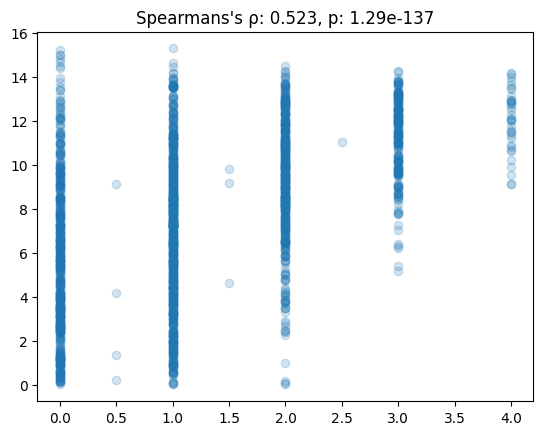

In [510]:
plt.scatter(radiff,pmdiff, alpha=0.2)
plt.title(f"Spearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")
plt.show()

Text(0.5, 1.0, "Spearmans's ρ: 0.273, p: 1.15e-34")

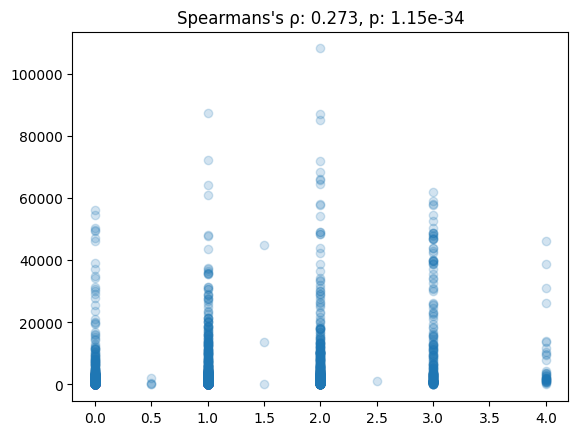

In [49]:
plt.scatter(radiff,mse,alpha=0.2)
plt.title(f"Spearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")

Seperate Classes:

In [9]:
omhn_norm = []
for i in range(len(omhn)):
    # print(omhn[i].min(), omhn[i].max())
    omhn_norm.append((omhn[i]/1302))

In [10]:
combinations = ((0,1),(0,2),(0,3),(0,4))

In [11]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

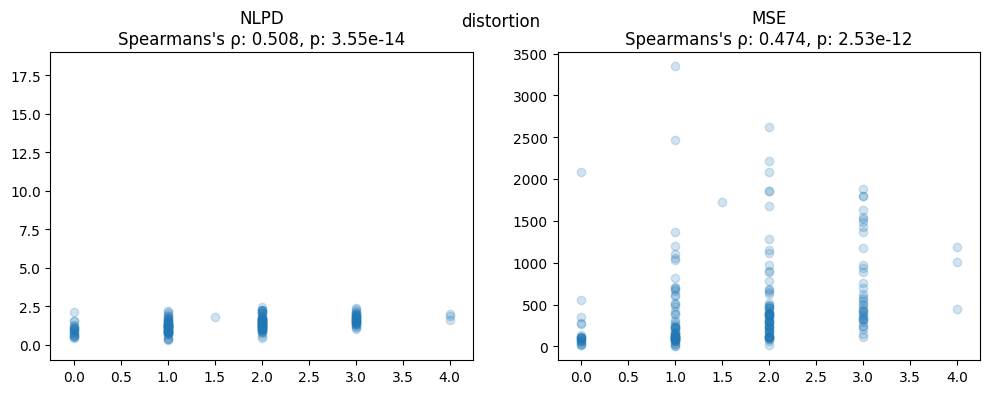

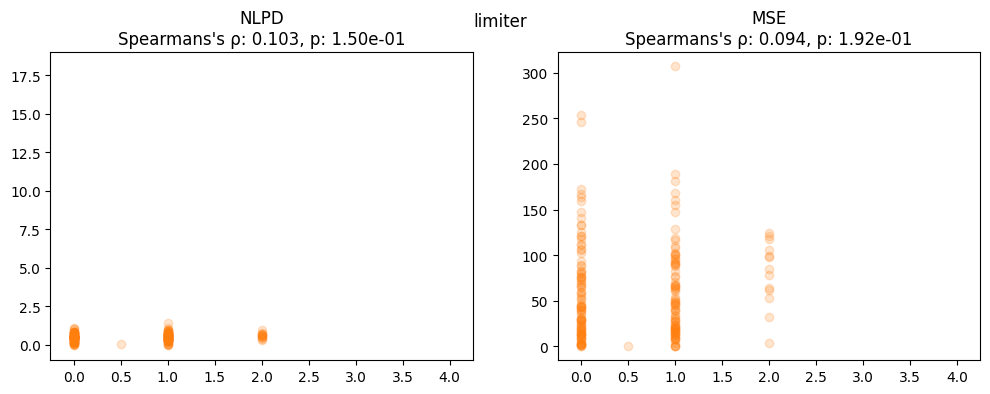

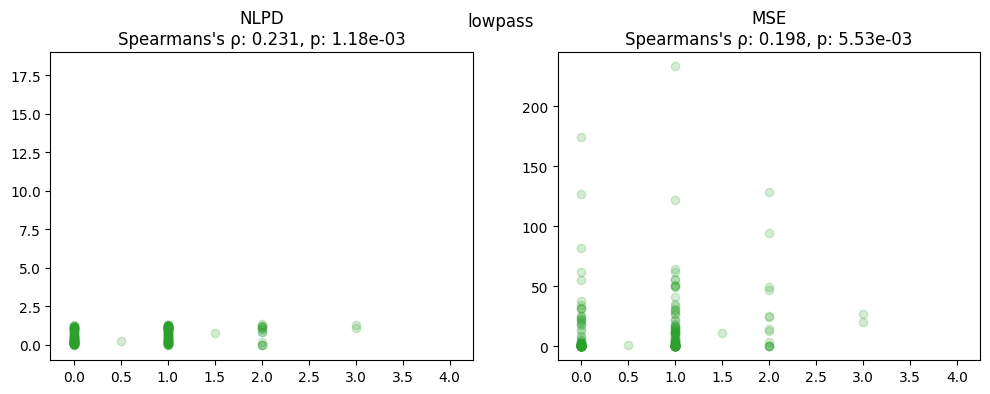

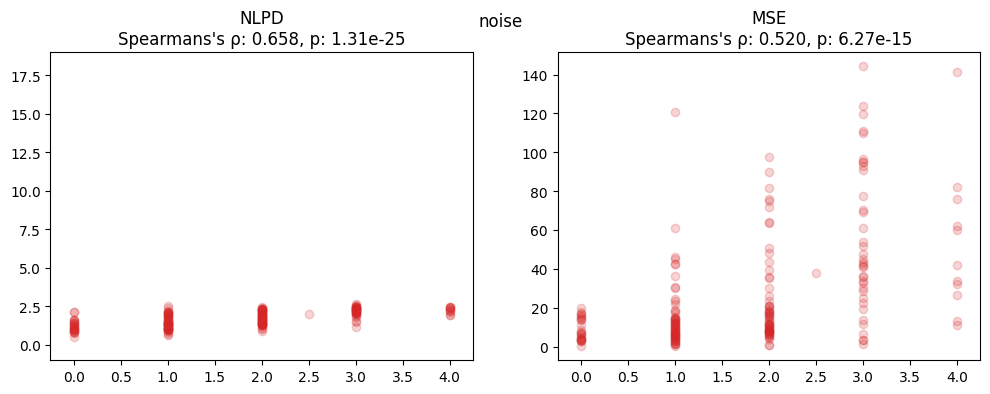

In [55]:
distortions = ['distortion','limiter','lowpass','noise']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn_norm[i1][j].unsqueeze(0).unsqueeze(0).float()*255, omhn_norm[i2][j].unsqueeze(0).unsqueeze(0).float()*255))
        mse.append(((omhn_norm[i1][j]*255-omhn_norm[i2][j]*255)**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))

    sppm = spearmanr(radiff,pmdiff)
    spmse = spearmanr(radiff,mse)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"NLPD\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")

    ax[0].scatter(radiff,pmdiff, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,18+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MSE\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,mse, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)

    plt.show()

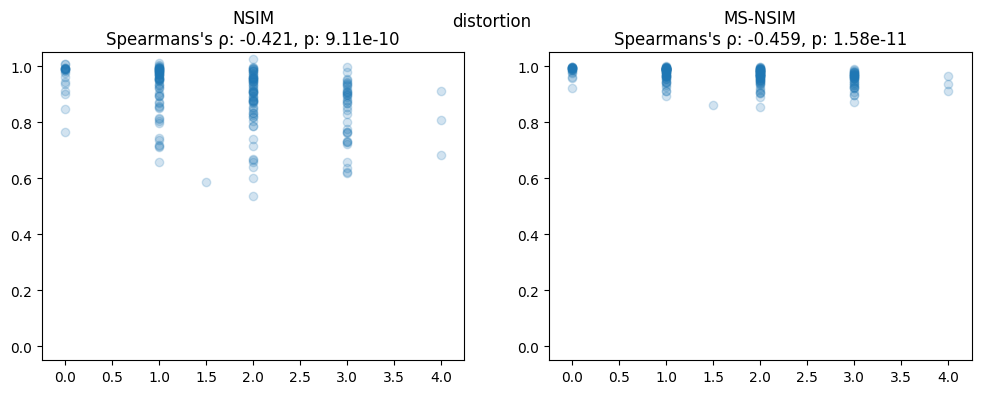

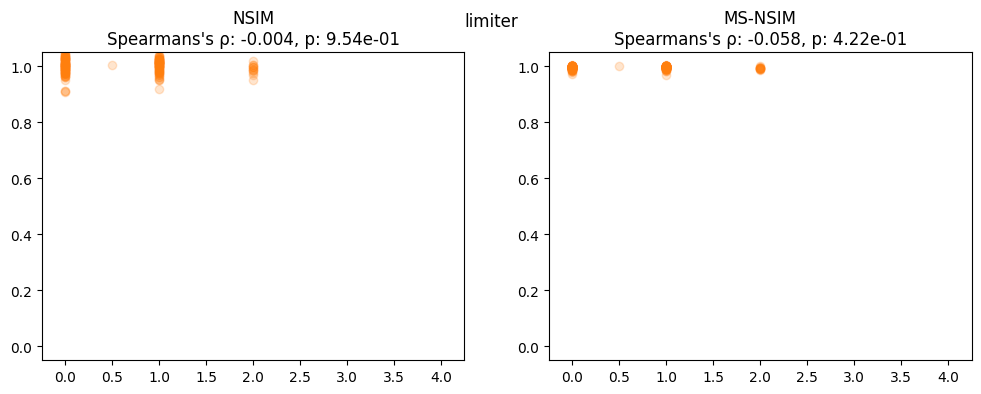

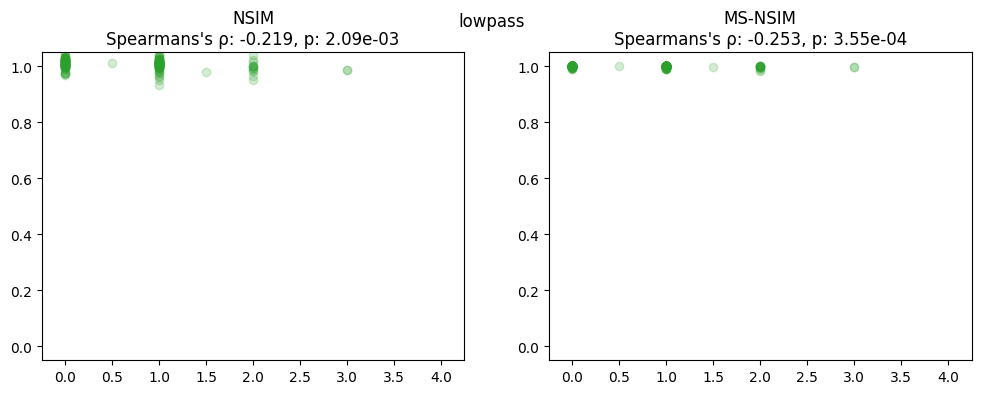

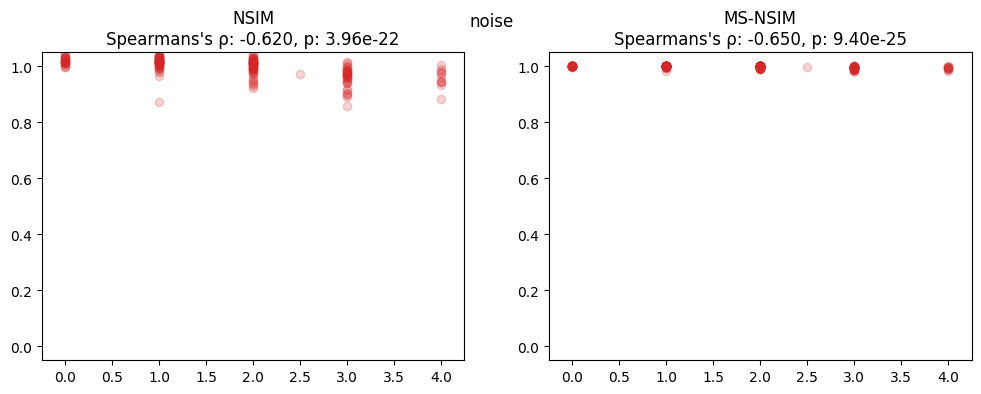

In [12]:
distortions = ['distortion','limiter','lowpass','noise']
from pytorch_msssim import ssim, ms_ssim

for i1, i2 in combinations:
    radiff= abs(rts[i1]-rts[i2])
    ssim_val = ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1,win_size = 7, size_average=False) # return (N,)
    ms_ssim_val = ms_ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1, win_size=7, size_average=False ) #(N,)

    """
    win size was 11 in original code, but changed here to 7 to accomodate smaller images for downscaling
    """

    spssim = spearmanr(radiff, ssim_val)
    spmsssim = spearmanr(radiff, ms_ssim_val)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 0.05

    ax[0].set_title(f"NSIM\nSpearmans's ρ: {spssim.statistic:.3f}, p: {spssim.pvalue:.2e}")

    ax[0].scatter(radiff,ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,1+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MS-NSIM\nSpearmans's ρ: {spmsssim.statistic:.3f}, p: {spmsssim.pvalue:.2e}")
    ax[1].scatter(radiff, ms_ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    ax[1].set_ylim(0-yoffset,1+yoffset)

    plt.show()

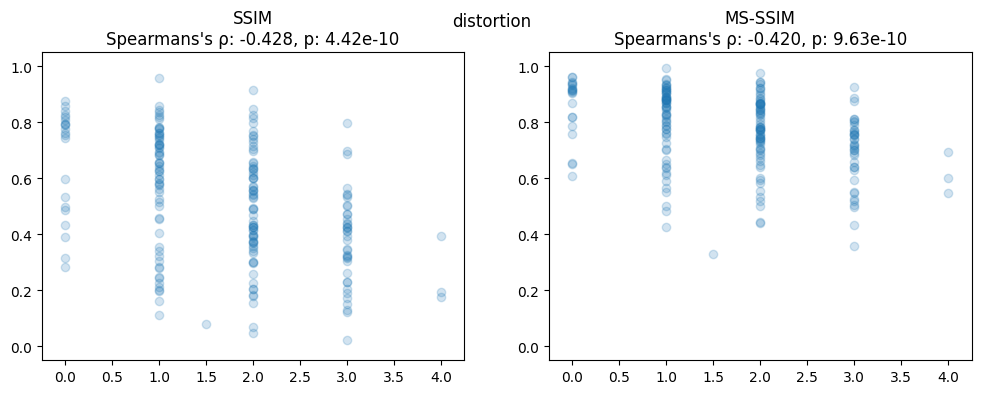

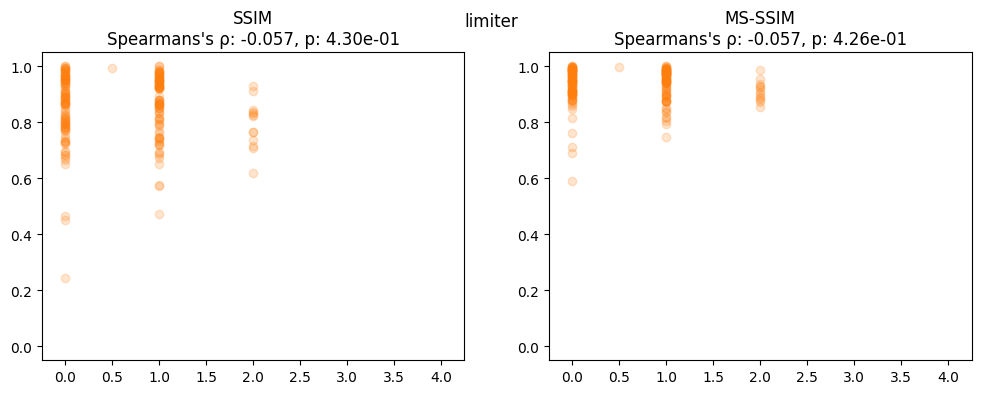

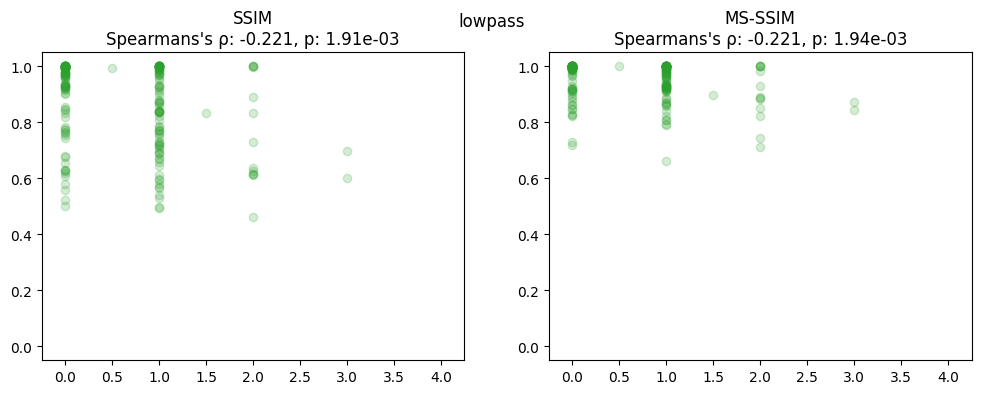

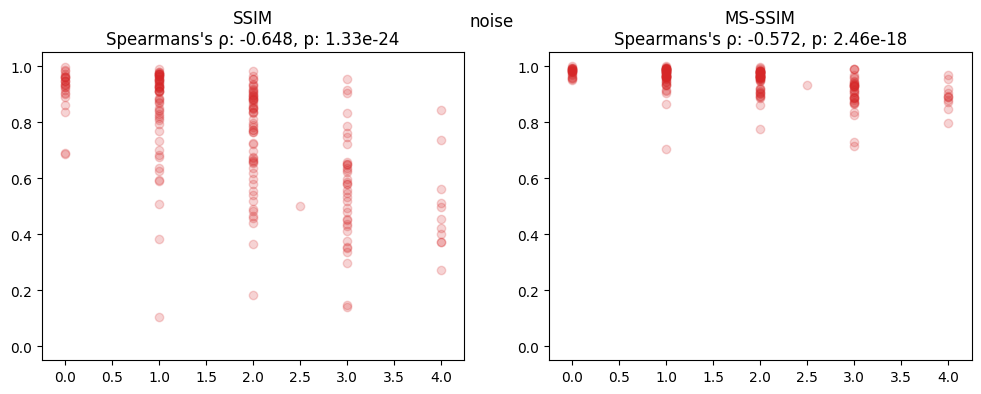

In [513]:
distortions = ['distortion','limiter','lowpass','noise']
from pytorch_msssim import ssim, ms_ssim

for i1, i2 in combinations:
    radiff= abs(rts[i1]-rts[i2])
    ssim_val = ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1,win_size = 7, size_average=False) # return (N,)
    ms_ssim_val = ms_ssim(omhn_norm[i1].unsqueeze(1), omhn_norm[i2].unsqueeze(1), data_range=1, win_size=7, size_average=False ) #(N,)

    """
    win size was 11 in original code, but changed here to 7 to accomodate smaller images for downscaling
    """

    spssim = spearmanr(radiff, ssim_val)
    spmsssim = spearmanr(radiff, ms_ssim_val)


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 0.05

    ax[0].set_title(f"SSIM\nSpearmans's ρ: {spssim.statistic:.3f}, p: {spssim.pvalue:.2e}")

    ax[0].scatter(radiff,ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[0].set_ylim(0-yoffset,1+yoffset)
    ax[0].set_xlim(0-xoffset,4+xoffset)

    ax[1].set_title(f"MS-SSIM\nSpearmans's ρ: {spmsssim.statistic:.3f}, p: {spmsssim.pvalue:.2e}")
    ax[1].scatter(radiff, ms_ssim_val, alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    ax[1].set_ylim(0-yoffset,1+yoffset)

    plt.show()

In [31]:
df = pd.read_csv('/Users/up20938/Coding/datasets/pmqd/visqol_scores.csv')

In [39]:
visqol = []
for j in range(4):
    dis = []
    for i in range(195):
        dis.append(df.loc[i+(j*195)]['moslqo'])
    visqol.append(dis)

In [51]:
df2 = pd.read_csv('/Users/up20938/Coding/datasets/pmqd/fads.csv',header=None)

In [ ]:
fads = []
for j in range(4):
    dis = []
    for i in range(195):
        dis.append(df2.loc[i+(j*195)][0])
    fads.append(dis)

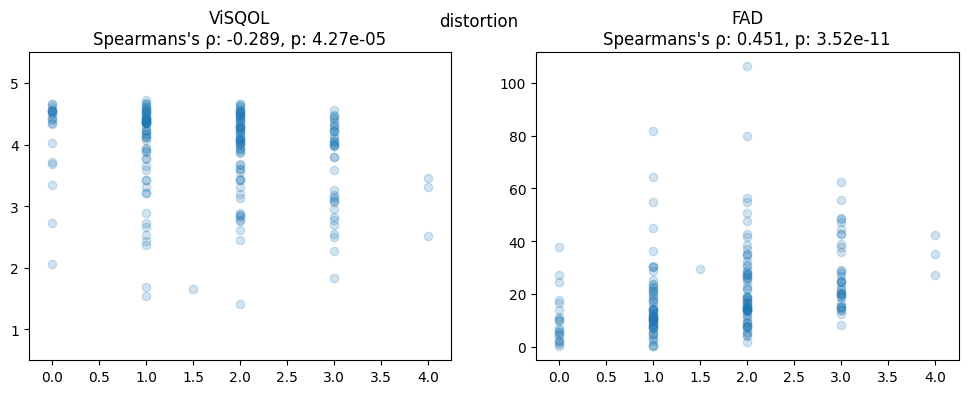

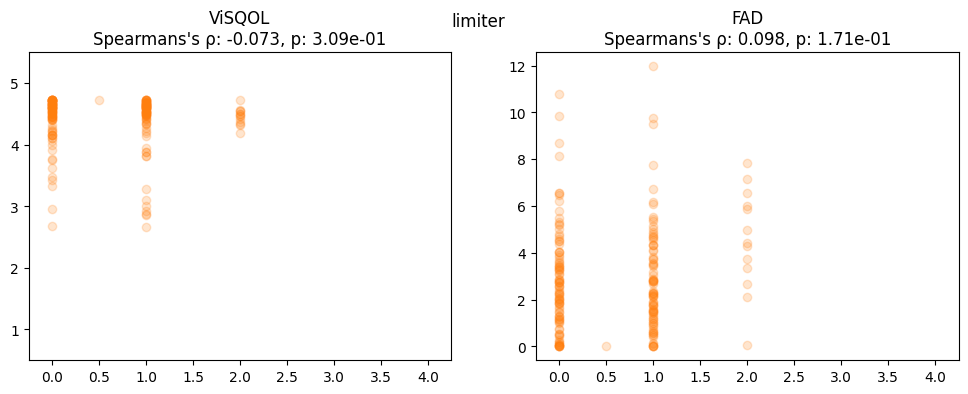

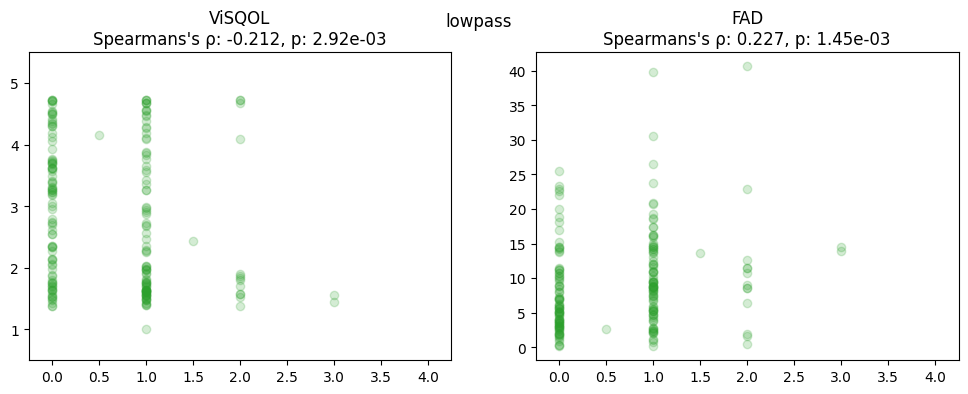

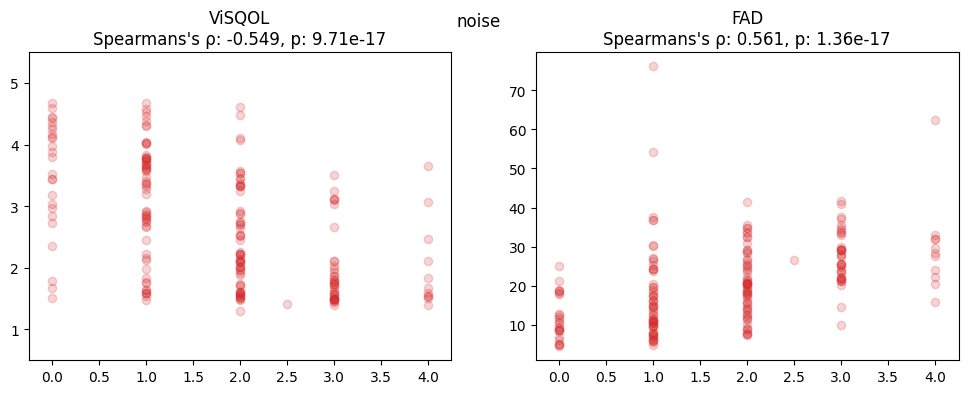

In [64]:
distortions = ['distortion','limiter','lowpass','noise']
for i1, i2 in combinations:
    pmdiff = []
    radiff = []
    mse = []
    for j in range(195):
        pmdiff.append(pmd.compare(omhn_norm[i1][j].unsqueeze(0).unsqueeze(0).float()*255, omhn_norm[i2][j].unsqueeze(0).unsqueeze(0).float()*255))
        mse.append(((omhn_norm[i1][j]*255-omhn_norm[i2][j]*255)**2).mean())
        radiff.append(abs(rts[i1][j]-rts[i2][j]))


    sppm = spearmanr(radiff,visqol[i2-1])
    spmse = spearmanr(radiff,fads[i2-1])


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plt.suptitle(distortions[i2-1])

    xoffset = 0.25
    yoffset = 1

    ax[0].set_title(f"ViSQOL\nSpearmans's ρ: {sppm.statistic:.3f}, p: {sppm.pvalue:.2e}")
    ax[0].scatter(radiff,visqol[i2-1], alpha=0.2, c=cycle[i2-1])
    ax[0].set_xlim(0-xoffset,4+xoffset)
    ax[0].set_ylim(1-yoffset/2,5+yoffset/2)

    ax[1].set_title(f"FAD\nSpearmans's ρ: {spmse.statistic:.3f}, p: {spmse.pvalue:.2e}")
    ax[1].scatter(radiff,fads[i2-1], alpha=0.2, c=cycle[i2-1])
    ax[1].set_xlim(0-xoffset,4+xoffset)
    # ax[1].set_ylim(1-yoffset/2,5+yoffset/2)

    plt.show()

In [18]:
# for i in random.choices(range(len(dataset)), k=5):
for i in range(0,975,195):
    example = dataset[i]
    audio, rating = example["audio"], example["rating"]

    degradation_type = example["degradation_type"]
    degradation_intensity = example["degradation_intensity"]

    print(f"Degradation {degradation_type}({degradation_intensity:.2f}%) with rating {rating}: ")
    display(Audio(audio.numpy(), rate=sample_rate))

Degradation original(0.00%) with rating 4.0: 


Degradation distortion(44.74%) with rating 2.0: 


Degradation limiter(4.46%) with rating 4.0: 


Degradation lowpass(71.93%) with rating 3.0: 


Degradation noise(51.41%) with rating 2.0: 
